In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

from SPINN import SPINN
from SLoader import SLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


4.3491209567037004e-07 0.0012473572278395295


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_std = torch.tensor(x_std[0]).unsqueeze(1)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:53: UserWarning: To copy constr

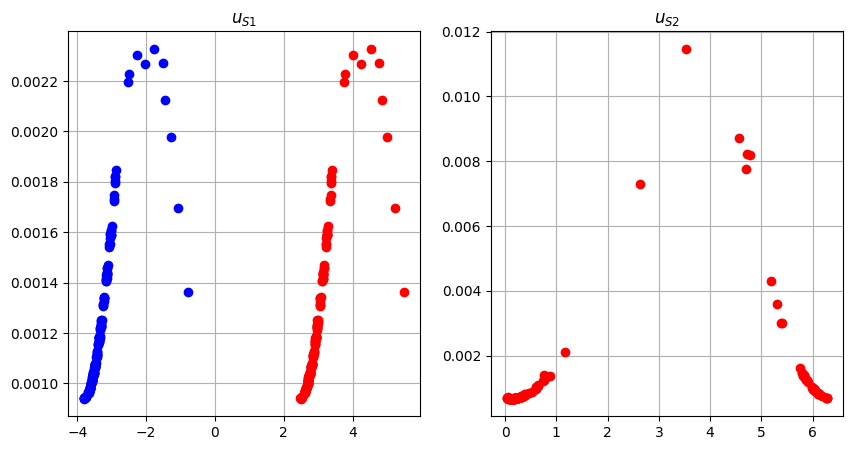

In [138]:
S1_scaling = 6e-5

#S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=S1_scaling)
S1 = SLoader(files=["data/S1_astrometry_data.csv"])
S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"], augment_data=True, std_data=True)

scaling1 = torch.mean(S1.u).item() 
scaling2 = torch.mean(S2.u).item()
print(scaling1, scaling2)

S1_scaling = scaling1/scaling2

S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=S1_scaling, augment_data=True, std_data=True)
#S1 = SLoader(files=["data/S1_astrometry_data.csv"], scaling=scaling1, std_data=True)
#S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"], scaling=scaling2, std_data=True)

u1 = S1.u
u2 = S2.u
phi1 = S1.phi
phi2 = S2.phi

phi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].set_title(r"$u_{S1}$")
ax[0].plot(phi1, u1, 'ro')

ax[0].plot(phi1-2*torch.pi, u1, 'bo');


ax[1].grid()
ax[1].set_title(r"$u_{S2}$")
ax[1].plot(phi2, u2, 'ro');



In [139]:
print(u1.min(), u1.max())
print(u2.min(), u2.max())

tensor(0.0009) tensor(0.0023)
tensor(0.0007) tensor(0.0115)


In [ ]:
# Initialize model
lr = 1e-4

model = SPINN(1, 1, chans=[1,1,1], norm1=S1_scaling).to(device) # 8, 16, 16, 8
print(model.S1.get_mu())
print(model.S2.get_mu())
#model.set_norm(scaling1, scaling2)
#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters())

# optimizer = optim.Adam([{'params': model.S1.nn.parameters(), 'lr': 1e-3},
#                        {'params': model.S2.nn.parameters(), 'lr': 1e-3},
#                        {'params': model.S2.e_, 'lr': 1e-4},
#                        {'params': model.S2.mu_, 'lr': 1e-2},
#                        {'params': model.S1.e_, 'lr': 1e-4}, 
#                        {'params': model.S1.mu_, 'lr': 1e-5},
#                        {'params': model.M_, 'lr': 1e-6}])

criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses1 = [[], [], []]
losses2 = [[], [], []]
params1 = [[], []]
params2 = [[], []]
params3 = []

phi_lin_ = torch.linspace(-4.1*torch.pi, 6.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)

phys_loss_weight = 0.
#phys_loss_weight = 1e4

phys_loss_weight1 = 1e2
phys_loss_weight2 = 1e2
data_loss_weight1 = 1.
data_loss_weight2 = 1.

alpha = 0.125 #0.9999 #0.9 #0.99

w_mse1_old = 1.
w_mse2_old = 1.
w_phys1_old = 1.
w_phys2_old = 1.

batch_size = 16
batch_size_phys = 128

# TODO:
#   * try alpha = 1e-4 for more epochs (> 10_000)
#   * alpha = 1-1e-4
#   * Different loss, L1, rel. diff, ...

tensor(3.4867e-05, device='cuda:0', grad_fn=<AbsBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AbsBackward0>)


In [141]:
epochs = 10_000


# For rel.diff. loss use phys_loss_weight = 1e0

for epoch in tqdm(range(epochs)):
    phi1, u1 = S1()
    phi2, u2 = S2()

    ind1 = torch.tensor(random.sample(range(len(phi1)), batch_size))
    ind2 = torch.tensor(random.sample(range(len(phi2)), batch_size))

    phi1 = phi1[ind1]
    u1 = u1[ind1]
    phi2 = phi2[ind2]
    u2 = u2[ind2]

    phi1 = phi1.to(device); phi2 = phi2.to(device)
    u1 = u1.to(device); u2 = u2.to(device)

    ind = torch.tensor(random.sample(range(len(phi_lin_)), batch_size_phys))
    phi_lin = phi_lin_[ind].to(device)

    
    out1, out2 = model(phi1, phi2)

    #MSEloss1 = criterion(out1, u1)
    #MSEloss2 = criterion(out2, u2)

    #MSEloss1 = criterion(torch.log(out1), torch.log(u1))
    #MSEloss2 = criterion(torch.log(out2), torch.log(u2))
    #MSEloss1 = criterion(1./out1, 1./u1)
    #MSEloss2 = criterion(1./out2, 1./u2)
    #MSEloss1 = criterion(torch.log(out1 + 1e-8), torch.log(u1 + 1e-8))    # Minimize relative difference
    #MSEloss2 = criterion(torch.log(out2 + 1e-8), torch.log(u2 + 1e-8))    # Minimize relative difference

    MSEloss1 = torch.mean(torch.abs(out1 - u1) / (torch.abs(u1) + 1e-8))    # Minimize MSE weightet by r
    MSEloss2 = torch.mean(torch.abs(out2 - u2) / (torch.abs(u2) + 1e-8))

    #PHYSloss1, PHYSloss2 = model.physical_loss(phi_lin)
    PHYSloss1 = model.S1.physical_loss(phi_lin, lambda1=1., lambda2=1.)
    PHYSloss2 = model.S2.physical_loss(phi_lin, lambda1=1., lambda2=1.)

    w_mse1 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/MSEloss1).item()
    w_mse2 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/MSEloss2).item()
    w_phys1 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/PHYSloss1).item()
    w_phys2 = ((MSEloss1 + MSEloss2 + PHYSloss1 + PHYSloss2)/PHYSloss2).item()

    #w_mse1 = ((MSEloss1 + PHYSloss1)/MSEloss1).item()
    #w_mse2 = ((MSEloss2 + PHYSloss2)/MSEloss2).item()
    #w_phys1 = ((MSEloss1 + PHYSloss1)/PHYSloss1).item()
    #w_phys2 = ((MSEloss2 + PHYSloss2)/PHYSloss2).item()

    w_mse1 = alpha * w_mse1_old + (1 - alpha) * w_mse1
    w_mse2 = alpha * w_mse2_old + (1 - alpha) * w_mse2
    w_phys1 = alpha * w_phys1_old + (1 - alpha) * w_phys1
    w_phys2 = alpha * w_phys2_old + (1 - alpha) * w_phys2

    MSEloss1 *= w_mse1
    MSEloss2 *= w_mse2
    PHYSloss1 *= w_phys1
    PHYSloss2 *= w_phys2


    loss1 = MSEloss1 + PHYSloss1
    loss2 = MSEloss2 + PHYSloss2

    loss = loss1 + loss2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses1[0].append(loss1.cpu().detach().numpy())
    losses1[1].append(MSEloss1.cpu().detach().numpy())
    losses1[2].append(PHYSloss1.cpu().detach().numpy())

    losses2[0].append(loss2.cpu().detach().numpy())
    losses2[1].append(MSEloss2.cpu().detach().numpy())
    losses2[2].append(PHYSloss2.cpu().detach().numpy())

    params1[0].append(model.S1.get_e().item())
    params1[1].append(model.S1.get_mu().item())

    params2[0].append(model.S2.get_e().item())
    params2[1].append(model.S2.get_mu().item())

    params3.append(model.get_M().item())

    w_mse1_old = w_mse1
    w_mse2_old = w_mse2
    w_phys1_old = w_phys1
    w_phys2_old = w_phys2

  0%|          | 0/10000 [00:00<?, ?it/s]

/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(phi, dtype=torch.float32), torch.tensor(u, dtype=torch.float32) # norm const
100%|██████████| 10000/10000 [05:23<00:00, 30.92it/s]


In [142]:
print(w_mse1)
print(w_mse2)
print(w_phys1)
print(w_phys2)


12.179443727638802
4.591150411661313
2.119857484321259
1.9538070730626578


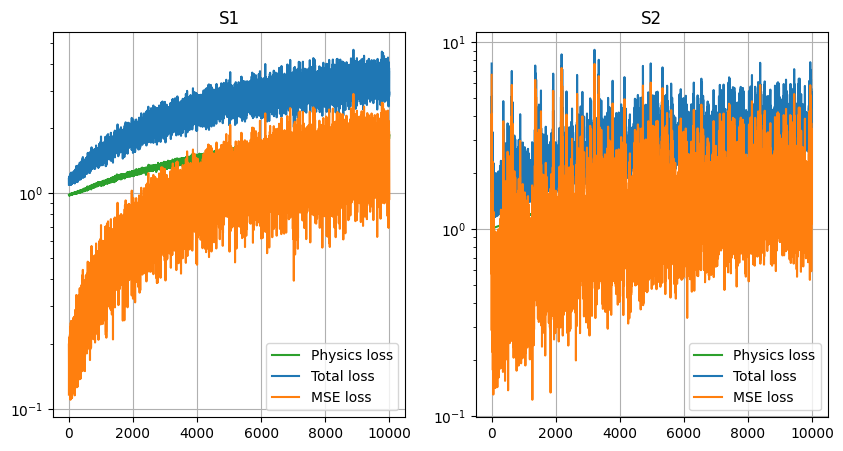

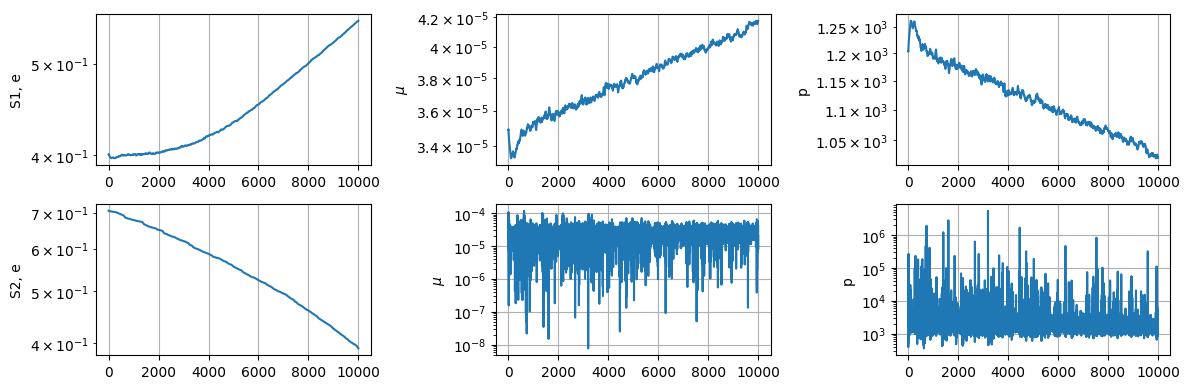

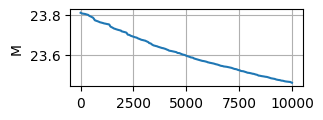

In [143]:

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("S1")
ax[0].plot(losses1[2], label="Physics loss", c="tab:green")
ax[0].plot(losses1[0], label="Total loss", c="tab:blue")
ax[0].plot(losses1[1], label="MSE loss", c="tab:orange")

ax[1].set_title("S2")
ax[1].plot(losses2[2], label="Physics loss", c="tab:green")
ax[1].plot(losses2[0], label="Total loss", c="tab:blue")
ax[1].plot(losses2[1], label="MSE loss", c="tab:orange")

[[axi.grid(), axi.legend(), axi.set_yscale("log")] for axi in ax]
#[[axi.grid(), axi.legend()] for axi in ax]
plt.show()


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,4))
[[[axij.set_yscale("log")] for axij in axi] for axi in ax] # set all yscale to log

ax[0,0].plot(params1[0])
ax[0,0].set_ylabel("S1, e")
ax[0,0].grid()

ax[0,1].plot(params1[1])
ax[0,1].set_ylabel(r"$\mu$")
ax[0,1].grid()

ax[0,2].plot(1/np.array(params3)/np.array(params1[1]))
ax[0,2].set_ylabel("p")
ax[0,2].grid()

ax[1,0].plot(params2[0])
ax[1,0].set_ylabel("S2, e")
ax[1,0].grid()

ax[1,1].plot(params2[1])
ax[1,1].set_ylabel(r"$\mu$")
ax[1,1].grid()

ax[1,2].plot(1/np.array(params3)/np.array(params2[1]))
ax[1,2].set_ylabel("p")
ax[1,2].grid()

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(3,1))
ax.set_ylabel("M")
ax.plot(params3)
ax.grid()

In [144]:

print("\n===== S1 =====")
print("e =", model.S1.get_e().item())
print("p =", 1/model.get_M().item()/model.S1.get_mu().item()*model.norm1)
#print("p =", model.S2.get_p().item())
print("mu =", model.S1.get_mu().item())

print("\n===== S2 =====")
print("e =", model.S2.get_e().item())
print("p =", 1/model.get_M().item()/model.S2.get_mu().item()*model.norm2)
#print("p =", model.S2.get_p().item())
print("mu =", model.S2.get_mu().item())

print("\nM =", 1/model.get_M().item())


#M_md = torch.mean(1 - torch.abs(model(S1.phi.to(device)).cpu() - S1.u)/S1.u).item()
#print("M-model-data =", M_md)


# S2
# e  ~ 0.884 (0.884)
# p  ~ 228 (223) AU
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755



===== S1 =====
e = 0.5549399256706238
p = 1021.6727147836618
mu = 4.172195622231811e-05

===== S2 =====
e = 0.3913824260234833
p = 2140.0943646978744
mu = 1.991789940802846e-05

M = 0.04262618427974084


0.0
tensor(0.7317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0796, device='cuda:0', grad_fn=<MeanBackward0>)


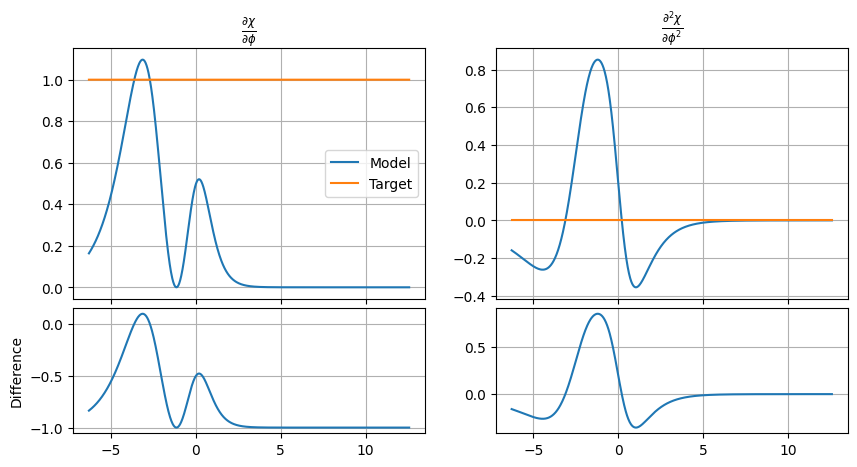

0.0
tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<MeanBackward0>)


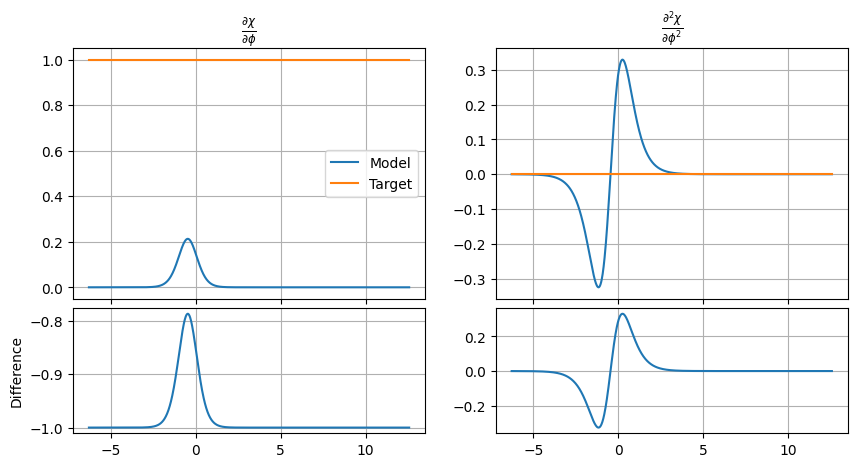

In [145]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True).to(device)
chi = model.S1.nn(_phi)

mu = model.S1.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.S1.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.cpu().detach().numpy()
dchi = dchi.cpu().detach().numpy()
ddchi = ddchi.cpu().detach().numpy()
chi = chi.cpu().detach()
ode1 = ode1.cpu().detach().numpy()
ode2 = ode2.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)
plt.show()

_phi = torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True).to(device)
chi = model.S2.nn(_phi)

mu = model.S2.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.S2.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.cpu().detach().numpy()
dchi = dchi.cpu().detach().numpy()
ddchi = ddchi.cpu().detach().numpy()
chi = chi.cpu().detach()
ode1 = ode1.cpu().detach().numpy()
ode2 = ode2.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)
plt.show()

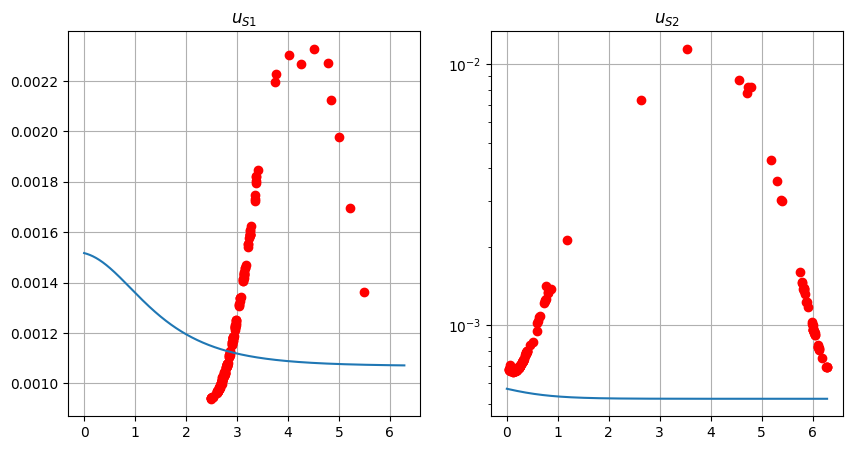

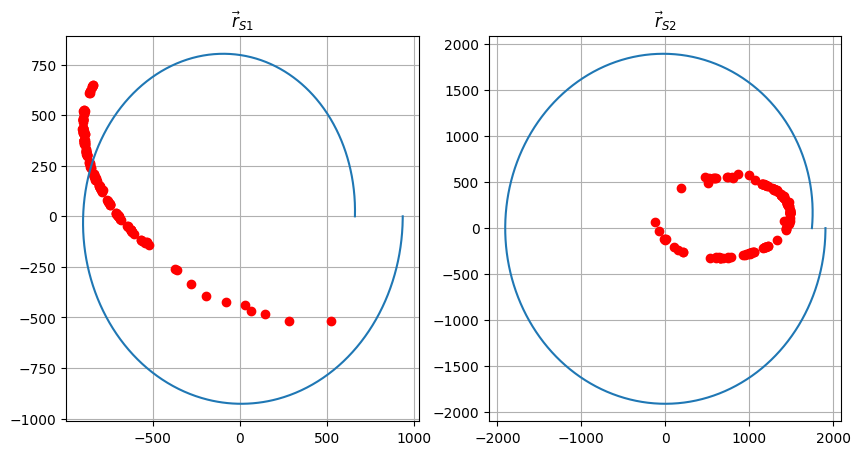

In [146]:
u1 = S1.u
u2 = S2.u
phi1 = S1.phi
phi2 = S2.phi

phi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1).to(device)

out1 = model.S1(phi, _M=model.get_M()).cpu().detach().numpy()
out2 = model.S2(phi, _M=model.get_M()).cpu().detach().numpy()

phi = phi.cpu()

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].set_title(r"$u_{S1}$")
ax[0].plot(phi1, u1, 'ro')
ax[0].plot(phi, out1)
#ax[0].set_yscale("log")

ax[1].grid()
ax[1].set_title(r"$u_{S2}$")
ax[1].plot(phi2, u2, 'ro')
ax[1].plot(phi, out2)
ax[1].set_yscale("log")



fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].grid()
ax[0].plot(torch.cos(phi1)/u1, torch.sin(phi1)/u1, 'ro')
ax[0].plot(torch.cos(phi)/out1, torch.sin(phi)/out1)
ax[0].set_title(r"$\vec{r}_{S1}$")

ax[1].grid()
ax[1].plot(torch.cos(phi2)/u2, torch.sin(phi2)/u2, 'ro')
ax[1].plot(torch.cos(phi)/out2, torch.sin(phi)/out2)
ax[1].set_title(r"$\vec{r}_{S2}$");


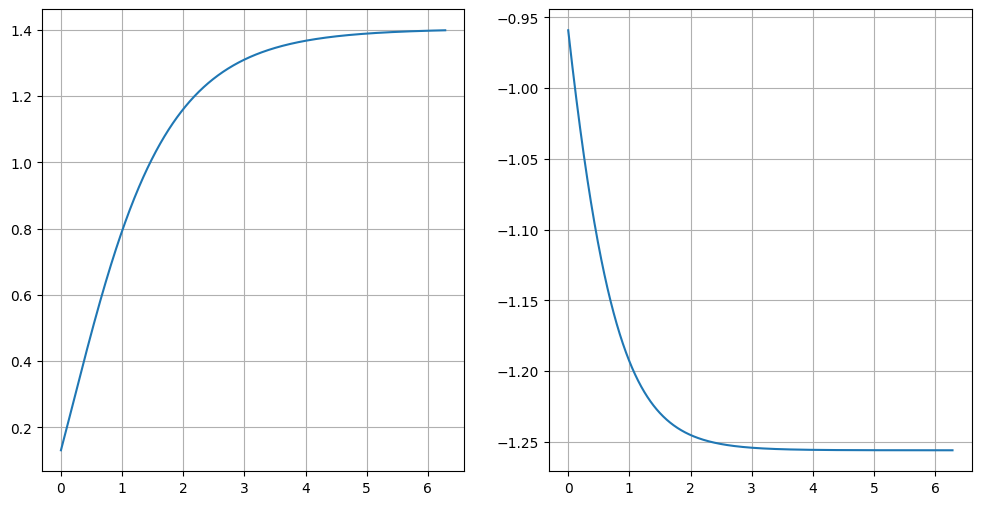

In [147]:
pphi = phi.to(device)

out1 = model.S1.nn(pphi).cpu().detach().numpy()
out2 = model.S2.nn(pphi).cpu().detach().numpy()

pphi = pphi.cpu()

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(pphi, out1)
ax[0].grid()

ax[1].plot(pphi, out2)
ax[1].grid()